# Траектории артиллерийских снарядов

### Дискретизация: Рунге-Кутта 4-го порядка

Сначала мы определяем набор значений дискретного времени $N$
$$
t_n=t_0+n\cdot h~~~~~\mathrm{with}~~~~n=0,1,2,3,...,N.
$$

$h$ - это длина временного шага и рассчитывается по формуле $h = \frac{t_N-t_0}{N}$, где $t_0$ и $t_N$ обозначают начальное и конечное значения времени полета снаряда. $N$ значений времени ставятся в соответствие $N$ значений $x$, $y$, $u$ и $w$, каждое из которых обозначается $x_n$, $y_n$, $u_n$ и $w_n$. Более практичным способом обозначения этой коллекции значений является векторная форма
$$
\vec{w_n} = \begin{bmatrix}x_n \\ y_n \\ u_n \\ v_n\end{bmatrix}.
$$

Эта нотация позволяет элегантно реализовать метод Рунге-Кутты. Всегда можно свести обыкновенное дифференциальное уравнение порядка $q$ к задаче решения набора из двух связанных дифференциальных уравнений порядка $q-1$. У нас есть связанный набор из двух дифференциальных уравнений второго порядка, поэтому нам нужно решить набор из четырех связанных дифференциальных уравнений первого порядка. Введя функцию $f$, которая преобразует $\vec{w_n}$ способом, описанным уравнением (1), можно напрямую реализовать метод Рунге-Кутты. В нашем случае $f$ задается

$$
f(\vec{w_n} ) = f \begin{bmatrix}x_n \\ y_n \\ u_n \\ v_n\end{bmatrix} = \begin{bmatrix}u_n \\ v_n \\ -\frac{B}{m}\Big[ 1 - \frac{ay_n}{T_0} \Big]^\alpha \left(u_n-V_x\right)\Big[ (u_n-V_x)^2+(v_n-V_y)^2 \Big]^{1/2} \\ -\frac{B}{m}\Big[ 1 - \frac{ay_n}{T_0} \Big]^\alpha \left(v_n-V_y\right)\Big[ (u_n-V_x)^2+(v_n-V_y)^2 \Big]^{1/2}-mg\end{bmatrix},
$$
без зависимости от времени, так что 
$$
\dot{\vec{w_n}}=f(\vec{w_n})
$$

описывает полную систему дифференциальных уравнений. Для углубления в тему ознакомьтесь с [блокнотом по методу Рунге-Кутты](https://nbviewer.jupyter.org/urls/www.numfys.net/media/notebooks/runge_kutta_method.ipynb). Следующий код реализует этот метод и может быть легко обобщен для решения ОДУ еще более высокого порядка или ОДУ, описывающие трехмерную задачу. 

## Реализация

In [22]:
using Plots
using Printf

In [38]:
# Константы
g = 9.81         # Сила гравитации на килограмм на поверхности земли
alpha = 2.5      # Параметр в модели адиабатической плотности воздуха
a = 6.5e-3       # Параметр в модели адиабатической плотности воздуха
T_0 = 288        # Температура на уровне моря
m = 50           # Масса снаряда
B = 2e-3         # Константа, основанная на Парижской пушке
v_0 = 1640       # Начальная скорость
# Сила ветра. Это постоянная, которая никогда не меняется
V = zeros(2) # Начинаем с отсутствия ветра


2-element Vector{Float64}:
 0.0
 0.0

In [39]:
function f(w)
    """ Функция, описывающая правую часть уравнений движения/систему ОДУ.
    Параметр:
        w       вектор, содержащий необходимые координаты и их скорости 
    """
    # V : вектор, описывающий силу и направление ветра
    temp_vector = zeros(4)
    temp_vector[1] = w[3]
    temp_vector[2] = w[4]
    # Сохранение следующих параметров для оптимизации времени выполнения
    k = 1 - a * w[2] / T_0   # Фактор плотности воздуха
    s = sqrt( (w[3]-V[1])^2 + (w[4]-V[2])^2 )
    if k > 0
        temp_vector[3] = -B / m * k^alpha * (w[3]-V[1]) * s
        temp_vector[4] = -B / m * k^alpha * (w[4]-V[2]) * s - g
    else
        temp_vector[3] = 0 
        temp_vector[4] = -g
    end
    return temp_vector 
end

function RK4_step(f, w, h)
    """Выполнение одного шага метода Рунге-Кутты четвертого порядка.
    Параметры:
        f      правая часть ОДУ для интегрирования
        w      численное приближение w в момент времени t
        h      единичный/интеграционный шаг
    Возвращает:
        численное приближение w в момент времени t+h
    """
    s1 = f(w)
    s2 = f(w + 0.5*h*s1)
    s3 = f(w + 0.5*h*s2)
    s4 = f(w + h * s3)
    return w + h*(s1 + 2*s2 + 2*s3 + s4)/6
end


RK4_step (generic function with 1 method)

Теперь мы можем  начать исследовать траектории снарядов парижской пушки. Нижеприведенные функции будут полезны в будущем.

In [44]:
function shoot(theta, v0)
    """ Инициализирует вектор w (x и y положение и скорость
    снаряда) с учетом начального угла стрельбы theta и
    абсолютной скорости v0. 
    """
    w = zeros(4)
    w[3] = v0 * cos(deg2rad(theta))
    w[4] = v0 * sin(deg2rad(theta))
    return w
end

function projectile_motion(h, theta)
    """ Рассчитывает движение снаряда, используя описанные выше функции.
    Пока снаряд находится в воздухе (w[1] >= 0), положение и скорость
    обновляются с использованием одного шага метода Рунге-Кутты четвертого порядка.
    Параметры:
        h        единичный/интеграционный шаг
        theta    начальный угол стрельбы
    Возвращает:
        X_list   массив x-положений снаряда
        Y_list   массив y-положений снаряда
    """
    w = shoot(theta, v_0)
    X_list = Float64[]
    Y_list = Float64[]
    while w[2] >= 0
        w = RK4_step(f, w, h)
        push!(X_list, w[1])
        push!(Y_list, w[2])
    end   
    return X_list, Y_list
end


projectile_motion (generic function with 1 method)

### Нахождение оптимального угла пуска
Без силы сопротивления тривиально показать, что угол, максимизирующий дальность полета снаряда, равен $\theta = 45^\circ$, где $\theta$ - угол между горизонтальной осью и направлением начальной скорости. Интересно посмотреть, как сопротивление воздуха влияет на этот максимальный угол, как с ветром, так и без него. Следующий код находит оптимальный угол с точностью до одного десятичного знака и показывает, как дальность зависит от угла стрельбы. Также поучительно увидеть некоторые траектории снаряда, поэтому некоторые из траекторий отображены. 

In [45]:
function find_optimal_angle(h)
    """ Задав шаг интеграции, эта функция вычисляет оптимальный начальный
    угол стрельбы для снаряда, чтобы достичь максимальной дальности по оси x.
    Возвращает набор протестированных углов с соответствующими дальностями
    и оптимальный угол.
    """
    
    record = 0        # Переменная-заполнитель, которая хранит максимальную дальность
    optimal_angle = 0 # Переменная-заполнитель, которая хранит угол, дающий максимальную дальность
    # Списки, содержащие начальный угол и соответствующую дальность
    theta_list = Float64[] 
    range_list = Float64[]
    for theta in range(1, 90, step = 2)
        x_list, y_list = projectile_motion(h, theta)
        # Использование линейной интерполяции для более точного определения точки приземления
        m = (y_list[end] - y_list[end-1]) / (x_list[end] - x_list[end-1])   # Точка приземления
        x_range = - y_list[end] / m + x_list[end] 
        push!(theta_list, theta)
        push!(range_list, x_range)
        # Обновление рекордов
        if x_range >= record
            record = x_range
            optimal_angle = theta
        end
    end
    # Повторение того же кода на меньшем интервале для более точного определения оптимального угла
    theta_list_smaller = range(optimal_angle - 2, optimal_angle + 2, length = 41)
    for theta_small in theta_list_smaller
        x_list, y_list = projectile_motion(h, theta_small)
        # Снова использование линейной интерполяции для более точного определения точки приземления
        m = (y_list[end] - y_list[end-1]) / (x_list[end] - x_list[end-1])
        x_range = - y_list[end] / m + x_list[end]
        if x_range >= record
            record = x_range
            optimal_angle = theta_small
        end
    end 
    return theta_list, range_list, optimal_angle
end


find_optimal_angle (generic function with 1 method)

In [46]:
θ, x, best = find_optimal_angle(0.1)
println("Оптимальный угол: ", best, " градусов")


Оптимальный угол: 55.7 градусов


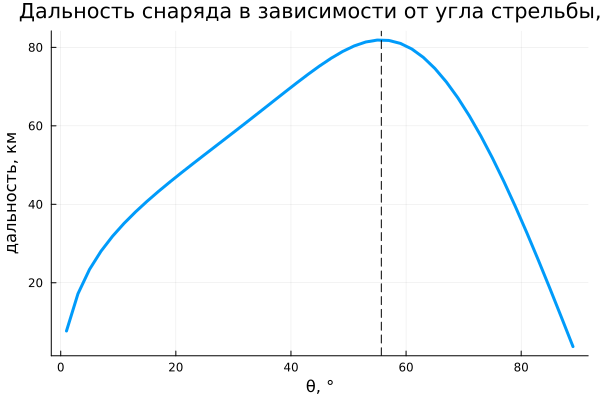

In [47]:
plot(θ, 0.001*x, line = 3, legend = false, xlab = "θ, °", ylab = "дальность, км")
title!("Дальность снаряда в зависимости от угла стрельбы, θ")
vline!([best], line = (:black, :dash))

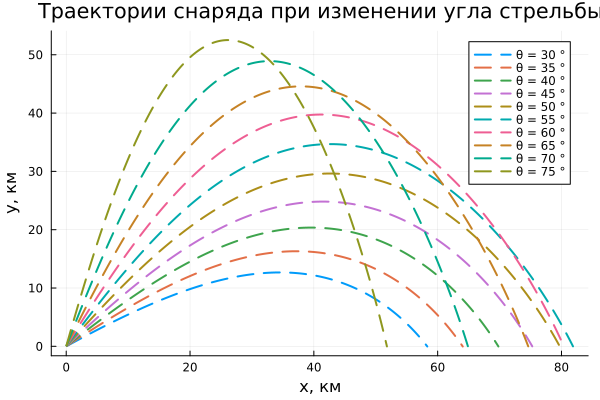

In [56]:
function trajectories(h)
    plot(xlab = "x, км", ylab = "y, км", 
        title = "Траектории снаряда при изменении угла стрельбы")

    theta_list = range(30, 75, step = 5)
    for angle in theta_list
        x_list, y_list = projectile_motion(h, angle)
        plot!(0.001*x_list, 0.001*y_list, line = (2, :dash), lab="θ = $angle °" )
    end
    plot!()
end
trajectories(0.1)

В отличие от движения снаряда без трения, максимальная дальность не достигается при угле стрельбы $\theta = 45^\circ$. Поскольку сила сопротивления ниже на больших высотах, дальность увеличивается, когда снаряд проводит большую часть своего полета на больших высотах. Это объясняет, почему максимальный диапазон получается при $\theta = 55^\circ$.

### Численная достоверность

Чтобы определить обоснованность численной реализации, мы можем проверить сохранение энергии. Во время траектории снаряда сила сопротивления $\vec{F_D}$ будет влиять на движение снаряда. Совокупная работа, проделанная над снарядом, определяется 

$$
W = \int \vec{F_D} \cdot \vec{dr}.
$$

В нашей дискретной модели мы можем легко вычислить этот интеграл, суммируя все бесконечно малые вклады и используя тот факт, что $\vec{F_D}$ всегда антипараллелен с $\vec{dr}$, так что совокупная работа в момент времени $t_M$, $M<N$, равна

$$
W = \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{r_n} - \vec{r_{n-1}}|,
$$
где $\vec{F_{D_{n-1}}}$ обозначает силу сопротивления в положении $\vec{r_{n-1}}$. Однако это снова можно записать в форму

$$
W = h \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{v_{n-1}}|,
$$
что наиболее удобно для наших целей. Следует отметить, что выбор индекса, который используется для силы и скорости соответственно, нетривиален, так как они оба будут меняться в течение интервала $dr$. Здесь используется как скорость снаряда, так и сила в точке $\vec{r_{n-1}}$. Это в основном прагматичный выбор, поскольку такая комбинация дает самые низкие и, следовательно, наиболее реалистичные потери энергии. Таким образом, мы можем, наконец, выразить энергию снаряда (которая, конечно, равна его кинетической и потенциальной энергии) и работу, проделанную в воздухе в момент времени $t_M$

$$
E(t_M) = h \sum_{n=1}^{M} |\vec{F_{D_{n-1}}}| \cdot |\vec{v_{n-1}}| + \frac{1}{2} m v_m^2 + mgy_m,
$$

где $v_m$ - абсолютная скорость снаряда, а $y_m$ - высота снаряда над землей (нулевая потенциальная точка отсчета).

Теперь все, что остается, - это проверить, действительно ли это выражение для энергии остается постоянным, пока снаряд находится в воздухе. 


В этом блокноте метод Рунге-Кутты реализован без особых трудностей. Однако интересно посмотреть, было ли необходимо использовать решатель дифференциальных уравнений 4-го порядка вместо использования самого примитивного решателя ОДУ, метода Эйлера. Следующий код будет использовать как метод Рунге-Кутты, так и метод Эйлера и сравнивать потери энергии во время движения для них обоих.

In [57]:
# Простая реализация метода Эйлера в векторной форме
euler_step(f ,w ,h) = w + h * f(w)

function energy_conservation(h, theta, func)
    """ Эта функция выполняет те же шаги, что и "движение_снаряда()" и "f()",
    но извлекает значение силы сопротивления, F_D, на каждом шаге. Это позволяет 
    вычислять работу и сохранять энергию на каждом временном шаге.
    Параметры:
        h           шаг интегрирования
        theta       начальный угол стрельбы
        func        функция, определяющая шаг интеграции (Эйлер или Рунге-Кутта 4)
    Возвращает:
        x_list      массив координат x траектории
        y_list      массив координат y траектории
        time_steps  массив временных шагов
        energy      массив энергии на каждом шаге
        work        общая работа силы сопротивления
    """
    w = shoot(theta, v_0)
    
    x_list = [0.0]
    y_list = [0.0]
    work = 0
    
     # Начальная полная энергия
    v = hypot(w[3], w[4])
    energy = [0.5*m*v^2]
    
    while w[2] >= 0
        w = func(f, w, h)
        
        # Обновление списков
        push!(x_list, w[1])
        push!(y_list, w[2])
        ## Временные параметры для проверки на большой высоте
        k = 1.0 - a*y_list[end-1]/T_0
        s = hypot( w[3]-V[1], w[4]-V[2] )
        if k > 0
            F_D = B * k^alpha * s^2
        else
            F_D = 0
        end
        # Добавление работы, выполненной силой сопротивления за этот интервал времени
        work +=  v * F_D * h
        # Обновление скорости для расчета полной энергии
        v = hypot(w[3], w[4])
        # Используйте np.sum на work_list, чтобы получить накопленную работу
        push!(energy, 0.5*m * v^2 + m*g*w[2] + work)
    end
    n = length(x_list)
    time_steps = range(0, stop = n*h, length = n)
    
    return x_list, y_list, time_steps, energy, work
end

energy_conservation (generic function with 1 method)

In [60]:
# Установка начальных значений
theta = 45
h = 0.1
# Получение результатов
x_list_euler, y_list_euler, time_steps_euler, energy_euler, work = 
            energy_conservation(h, theta, euler_step)
x_list_RK4, y_list_RK4, time_steps_RK4, energy_RK4, work = 
            energy_conservation(h, theta, RK4_step)

println("При угле стрельбы $theta градусов и временном шаге = $h секунд:")
de = energy_RK4[1] - energy_RK4[end]
dee = (energy_RK4[1] - energy_RK4[end]) / energy_RK4[1] * 100
@printf "Потеря энергии с методом Рунге-Кутта: %.3e = %.2f процентов от общей энергии\n" de dee
de = energy_euler[1] - energy_euler[end]
dee = (energy_euler[1] - energy_euler[end]) / energy_euler[1] * 100
@printf "Потеря энергии с методом Эйлера: %.3e = %.2f процентов от общей энергии" de dee

При угле стрельбы 45 градусов и временном шаге = 0.1 секунд:
Потеря энергии с методом Рунге-Кутта: -7.395e+03 = -0.01 процентов от общей энергии
Потеря энергии с методом Эйлера: 2.735e+05 = 0.41 процентов от общей энергии

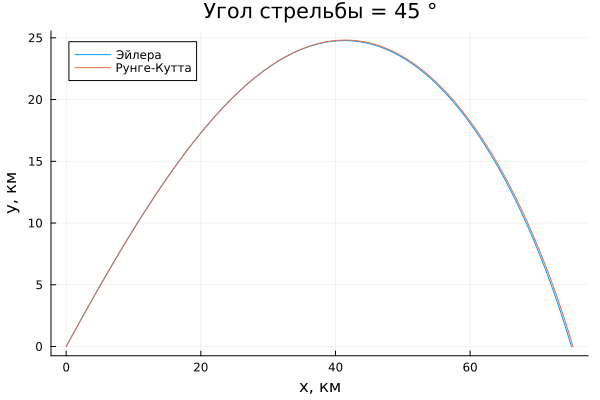

In [61]:
# Построение отдельных траекторий
plot(0.001*x_list_euler, 0.001*y_list_euler, lab ="Эйлера")
plot!(0.001*x_list_RK4, 0.001*y_list_RK4, lab ="Рунге-Кутта")
title!("Угол стрельбы = $theta °", xlab = "x, км", ylab = "y, км")

Из приведенного выше рисунка видно, что метод Эйлера работает на удивление хорошо, хотя это всего лишь решатель ОДУ первого порядка. Он выводит почти ту же траекторию, что и метод Рунге Кутты. Наиболее вероятным объяснением небольшой разницы между методом Рунге Кутты 4-го порядка и методом Эйлера является то, что связанный набор ОДУ, который мы решаем, довольно линеен, другими словами, производные изменяются довольно медленно. Таким образом, метод Эйлера дает удовлетворительные результаты, даже если он имеет только первый порядок.

Может показаться, что потеря около $10^3$ джоулей - это много, но нужно помнить об огромных размерах парижской пушки и о том, что это небольшая часть первоначальной энергии снаряда.

## Физика, стоящая за цифрами
Несмотря на то, что количество исчезнувшей энергии относительно невелико, все же интересно изучить природу потери. В нашем случае оказывается, что у нее есть объяснение, которое коренится как в физике, так и в числовых характеристиках проблемы. 

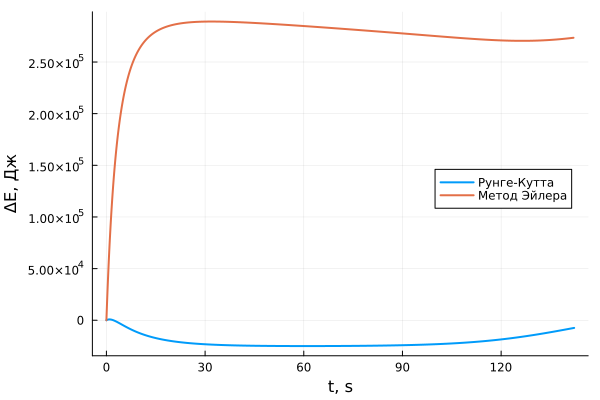

In [63]:
starting_energy_RK4 = fill(energy_RK4[1], length(energy_RK4))
starting_energy_euler = fill(energy_euler[1], length(energy_euler))

plot(time_steps_RK4, starting_energy_RK4 - energy_RK4, lab = "Рунге-Кутта", line = 2)
plot!(time_steps_euler, starting_energy_euler - energy_euler, lab = "Метод Эйлера", line = 2)
plot!(xlab = "t, s", ylab = "ΔE, Дж", legend = :right)

Исследование численной достоверности в зависимости от угла стрельбы

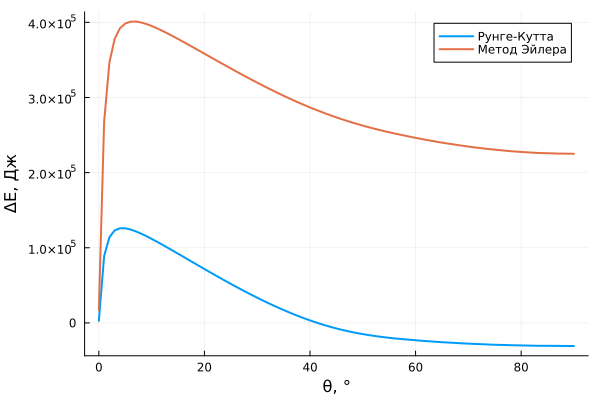

In [64]:
energy_loss_euler = Float64[]
energy_loss_RK4 = Float64[]
angles = Float64[]
for i in 0:90
    energy_euler = energy_conservation(0.1, i, euler_step)[4] # только возвращает четвертое значение возврата
    push!(energy_loss_euler, energy_euler[1] - energy_euler[end])
    energy_RK4 = energy_conservation(0.1, i, RK4_step)[4]
    push!(energy_loss_RK4, energy_RK4[1] - energy_RK4[end])
    push!(angles, i)
end

plot(angles, energy_loss_RK4, label ="Рунге-Кутта", line = 2)
plot!(angles, energy_loss_euler, label ="Метод Эйлера", line = 2)
plot!(xlab = "θ, °", ylab = "ΔE, Дж")

На первом рисунке показано, насколько энергия отличается от первоначальной энергии снаряда во время движения. Как метод Эйлера, так и метод Рунге-Кутты демонстрируют одинаковое численное поведение, основной вклад в ошибку в энергии происходит на более низких высотах, в начале и в конце траектории. Поскольку снаряд быстро достигает больших высот, где плотность воздуха ниже, сила сопротивления также будет уменьшаться. Когда сила сопротивления пренебрежимо мала, движение снаряда может быть аналитически описано выражением второго порядка, что является легкой задачей, особенно для Рунге-Кутты, поскольку это решатель ОДУ четвертого порядка. Ожидаются большие потери энергии в начале траектории для метода Эйлера: сила сопротивления пропорциональна $v^3$, и поскольку скорость намного выше в начале траектории, производные $u$ и $v$ будут меняться быстрее, и метод Эйлера в некотором смысле не поспевает. 

Те же объяснения справедливы и для второго рисунка. Чем меньше времени снаряд проводит на малых высотах, тем меньше потери энергии. Если угол стрельбы невелик, снаряд не достигнет высот, на которых плотность воздуха и потери энергии ниже. 

Исследование численной достоверности в зависимости от длины шага h

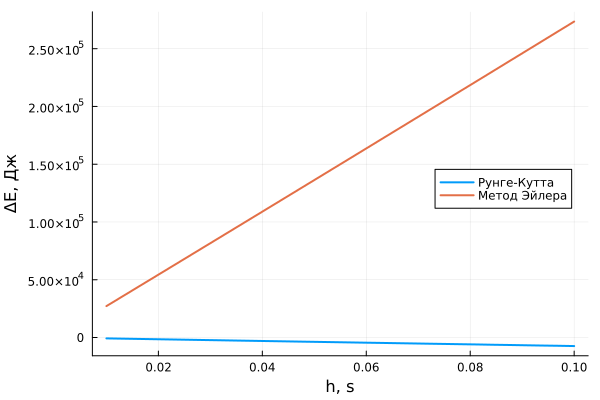

In [65]:
theta = 45
h_list = range(0.01, 0.1, length = 30)

energy_loss_euler = Float64[]
energy_loss_RK4 = Float64[]

for h in h_list
    energy_euler = energy_conservation(h, theta, euler_step)[4]
    push!(energy_loss_euler, energy_euler[1] - energy_euler[end])
    energy_RK4 = energy_conservation(h, theta, RK4_step)[4]
    push!(energy_loss_RK4, energy_RK4[1] - energy_RK4[end])
end

plot(h_list, energy_loss_RK4, label ="Рунге-Кутта", line = 2)
plot!(h_list, energy_loss_euler, label ="Метод Эйлера", line = 2)
plot!(xlab = "h, s", ylab = "ΔE, Дж", legend = :right)

Последняя численная проверка состоит в том, чтобы увидеть, как отклонение энергии зависит от длины временного шага $h$. Неудивительно, что отклонение уменьшается по мере того, как $h$ становится меньше, и ошибка кажется линейной как для метода Эйлера, так и для четвертого порядка Рунге-Кутты.

Что касается того, какой решатель ОДУ является лучшим для этого проекта, можно, конечно, утверждать, что более реалистичные результаты, полученные Рунге-Куттой четвертого порядка, делают его предпочтительным кандидатом. Особенно учитывая, что реализация Рунге-Кутты требует всего четырех дополнительных строк кода, трудно увидеть какие-либо серьезные недостатки использования Рунге-Кутты вместо метода Эйлера. Однако следует отметить, что они производят почти одинаковую траекторию, так что в качестве простой демонстрации траектории метод Эйлера будет работать просто отлично.

### Изучение воздействия ветра - Маленькая Берта

В этом разделе мы увидим, как ветер влияет на движение снаряда. Поскольку размеры парижской пушки слишком велики, чтобы на них могла повлиять какая-либо реальная сила ветра, используются размеры вымышленной пушки "Маленькая Берта". Название  происходит от серии пушек, использовавшихся Германией в Первой мировой войне - пушки этой серии обычно назывались "Большая Берта". Поскольку плотность воздуха будет примерно постоянной, теперь мы ожидаем, что максимальная дальность будет получена под углом ниже, чем ранее. 

Оптимальный угол: 40.2 градусов без учета ветра. 
Траектории без учета ветра:


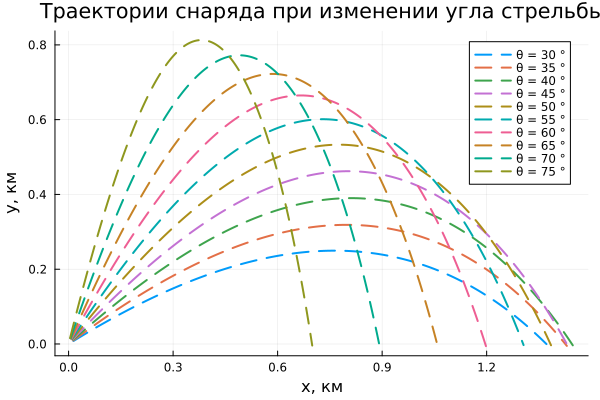

In [66]:
# Переинициализация переменных для масштабирования размеров относительно Парижской пушки
m = 10     # Масса снаряда
B = 5e-3   # Константа, основанная на Парижской пушке
v_0 = 164  #  Начальная скорость
# Сила ветра
V = zeros(2)

println("Оптимальный угол: ", find_optimal_angle(0.1)[3], 
      " градусов без учета ветра. \nТраектории без учета ветра:")            
trajectories(0.1)

Оптимальный угол: 42.5 градусов при сильном хвостовом ветре.
Траектории при сильном хвостовом ветре:

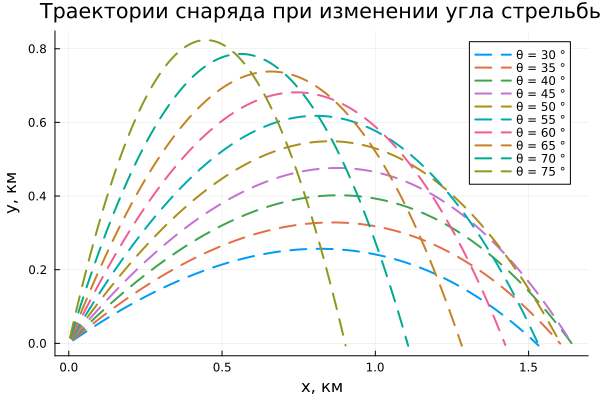

In [67]:
V[1] = 20 # Сильный хвостовой ветер в горизонтальном направлении
print("Оптимальный угол: ", find_optimal_angle(0.1)[3], 
      " градусов при сильном хвостовом ветре.", 
      "\nТраектории при сильном хвостовом ветре:")            
trajectories(0.1)

Оптимальный угол: 37.2 градусов при сильном встречном ветре.
Траектории при сильном встречном ветре:

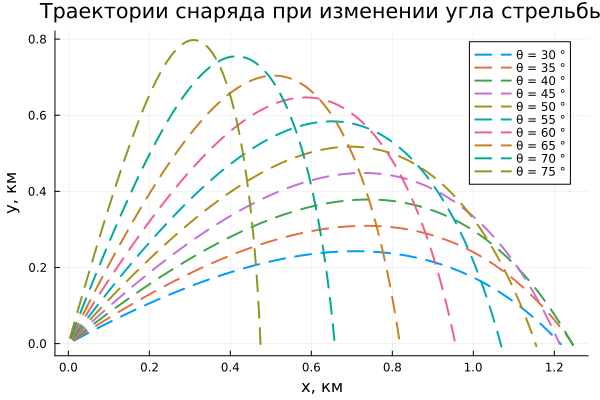

In [68]:
V[1] = -20 # Сильный встречный ветер в горизонтальном направлении
print("Оптимальный угол: ", find_optimal_angle(0.1)[3], 
      " градусов при сильном встречном ветре.", 
      "\nТраектории при сильном встречном ветре:")                     
trajectories(0.1)

Ветер влияет на траектории, как и ожидалось. Когда снаряд испытывает сильный попутный ветер, сила сопротивления уменьшается, что делает движение более похожим на аналитическую траекторию снаряда без трения. Таким образом, оптимальный угол стрельбы будет ближе к $45^\circ$ - оптимальному углу для движения снаряда без трения. Противоположный случай имеет место, когда снаряд испытывает сильный встречный ветер. Сила сопротивления увеличивается, что снижает оптимальный угол стрельбы, так как для снаряда будет лучше проводить как можно меньше времени в воздухе. 